# Utils

### Libraries

In [1]:
import pandas as pd
import os
import glob
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import contextlib
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
import hdbscan
import umap
import statsmodels.api as sm
import warnings
import sys

In [2]:
# Suppress all FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sys.path.append("/Users/emmatosato/Documents/PhD/ANM_Verona/src/data_processing")

In [67]:
import importlib
from data_processing import umap_clustering, umap_regression, clustering_evaluation, umap_run, processing_flat

importlib.reload(clustering_evaluation)
importlib.reload(umap_regression)
importlib.reload(umap_clustering)
importlib.reload(umap_run)
importlib.reload(processing_flat)


from data_processing.clustering_evaluation import evaluate_kmeans, evaluate_gmm, evaluate_hdbscan, evaluate_consensus
from data_processing.umap_regression import main_regression, plot_ols_diagnostics
from data_processing.umap_clustering import main_clustering
from data_processing.processing_flat import main_processing_flat

### Paths and folders

In [4]:
# FC maps mean
dir_FCmaps = '/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps'
dir_FCmaps_processed = '/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps_processed'
dir_data_utils = "/Users/emmatosato/Documents/PhD/ANM_Verona/data_utils/"
gm_mask_path = '/Users/emmatosato/Documents/PhD/ANM_Verona/utils/masks/GM_mask.nii'
harvard_oxford_mask_path = '/Users/emmatosato/Documents/PhD/ANM_Verona/utils/masks/mask_GM.nii'
atrophy_dataset_matches = '/Users/emmatosato/Documents/PhD/ANM_Verona/utils/metadata/atrophy_matched.xlsx'
cognitive_dataset ='/Users/emmatosato/Documents/PhD/ANM_Verona/utils/metadata/cognitive_dataset.xlsx'

# Data

### Load data

Function for listing the data in nii.gz format and extract the subjects identifiers + printing some infos

In [5]:
def listData_saveID(dir):
    # All nii.gz files in the directory
    files_path = sorted(glob.glob(os.path.join(dir, '*gz')))

    # Extract Subject IDs from filenames
    subject_id = [os.path.basename(f).replace('.FDC.nii.gz', '') for f in files_path]

    # Sanity checks
    assert len(files_path) == len(subject_id), (
        f"Mismatch count: {len(files_path)} files vs {len(subject_id)} IDs"
    )
    assert len(subject_id) == len(set(subject_id)), "ID duplicated"
    for fp, sid in zip(files_path, subject_id):
        fname = os.path.basename(fp)
        expected = sid + '.FDC.nii.gz'
        assert fname == expected, (
            f"Filename “{fname}” do not correspond to the extracted ID“{sid}”"
        )

    print("Check length:")
    print("Files: ", len(files_path))
    print("Subject: ", len(subject_id))

    return files_path, subject_id

In [6]:
files, sub_id = listData_saveID(dir_FCmaps)

Check length:
Files:  176
Subject:  176


In [7]:
maps_FDC = []
for path in files:
    print(path)
    data = nib.load(path).get_fdata().flatten()
    maps_FDC.append(data)

# Stores subjects as rows and voxels as columns
raw_df=pd.DataFrame(maps_FDC)

/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/002_S_4654.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/002_S_6695.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/003_S_6264.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/003_S_6268.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/003_S_6432.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/003_S_6479.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/003_S_6606.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/006_S_6252.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/006_S_6682.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/007_S_6341.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/011_S_4893.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/011_S_6303.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/012_S_4188.FDC.nii.gz

In [8]:
# Insert subjects id
raw_df.insert(0, 'ID', sub_id)
print("\n", raw_df.shape, "\n")


 (176, 902630) 



Some asserts

In [9]:
# Ensure the raw_df has one row per subject ID
assert raw_df.shape[0] == len(sub_id), (
    f"Number of rows ({raw_df.shape[0]}) != number of IDs ({len(sub_id)})"
)

# Verify the ID column matches the original sub_id order exactly
assert raw_df['ID'].tolist() == sub_id, "Row IDs do not match the original sub_id order"

# Confirm there are no duplicate IDs
assert raw_df['ID'].is_unique, "There are duplicate IDs in the DataFrame"

### Metadata

Dataset containing:
- ID of the subject
- The diagnosis (Group)
- Sex
- Age
- Education

The regressors:
- CDR_SB: disease gravity with a larger range
- CDR: same but smaller range

In [10]:
# Load the metadata and align to FC map order
df_meta = pd.read_excel(cognitive_dataset, sheet_name='Sheet1')
df_meta['Age'] = df_meta['Age'].round(1)

In [11]:
print("Meta dataset BEFORE removing a subject")
print(df_meta.shape)

# Remove the subject with ID "4_S_5003"
df_meta = df_meta[df_meta['ID'] != '4_S_5003'].reset_index(drop=True)

print("Meta dataset AFTER removing a subject")
print(df_meta.shape)

Meta dataset BEFORE removing a subject
(177, 7)
Meta dataset AFTER removing a subject
(176, 7)


### GMM on CDR_SB

Assigning each CDB_SB value to a cluster using GMM, removing NaN values before

In [12]:
# Filter valid CDR_SB values
df_cdr = df_meta[['ID', 'CDR_SB']].dropna().copy()
print("Dimensions after dropping NaN", df_cdr.shape)

# Fit GMM and predict raw labels
np.random.seed(42)
x_gmm = df_cdr['CDR_SB'].values.reshape(-1, 1)
gmm = GaussianMixture(n_components=3, random_state=42).fit(x_gmm)
df_cdr['GMM_Label'] = gmm.predict(x_gmm)

# Reorder labels by CDR_SB severity
means = df_cdr.groupby('GMM_Label')['CDR_SB'].mean().sort_values()
label_map = {old: new for new, old in enumerate(means.index)}
df_cdr['GMM_Label'] = df_cdr['GMM_Label'].map(label_map)

# Include in metadata
label_map = dict(zip(df_cdr['ID'], df_cdr['GMM_Label']))
df_meta = df_meta.drop(columns=['GMM_Label'], errors='ignore')
df_meta['GMM_Label'] = df_meta['ID'].map(label_map).astype('Int64')

Dimensions after dropping NaN (171, 2)


In [ ]:
print(df_meta['GMM_Label'].value_counts().sort_index())

# Analysis with UMAP

## Preprocessing

Recall the dataframe with ID and values of the maps

In [18]:
print(raw_df.shape,"and the metadata dataframe", df_meta.shape)

(176, 902630) and the metadata dataframe (176, 8)


STEPS:
- Aligning the metadata to the raw_df
- Set a threshold for values below 0.1 and 0.2
- Masking
- Possible output dataset:
    - `df_thr01_gm_masked`
    - `df_thr02_gm_masked`
    - `df_thr01_har_masked`
    - `df_thr02_har_masked`
    - `df_gm_masked`
    - `df_har_masked`


In [42]:
outputs, df_summary = main_processing_flat(
    raw_df=raw_df,
    df_meta=df_meta,
    target_col='CDR_SB',
    gm_mask_path=gm_mask_path,
    harvard_mask_path=harvard_oxford_mask_path,
    thresholds=[0.1, 0.2],
    do_eda=True
)

The IDs are now perfectly aligned
Thesholds applied
Masks applied
Processing completed


In [43]:
df_thr01_gm_masked   = outputs['thr_01_gm']
df_thr02_gm_masked   = outputs['thr_02_gm']
df_thr01_har_masked  = outputs['thr_01_har']
df_thr02_har_masked  = outputs['thr_02_har']
df_gm_masked         = outputs['gm_no_thr']
df_har_masked        = outputs['har_no_thr']

In [44]:
pd.options.display.float_format = '{:.4f}'.format
display(df_summary)

,Shape,Values between 0 and 1.0,Zero maps,All Min,All Max,All Mean,All Std,Nonzero Min,Nonzero Max,Nonzero Mean,Nonzero Std,Values between 0 and 2.0
Dataset,,,,,,,,,,,,
thr_01_gm,"(171, 161818)",True,0 of 171,0.0000,1.6188,0.0734,0.1020,0.1000,1.6188,0.1829,0.0767,NaN
thr_02_gm,"(171, 161818)",NaN,0 of 171,0.0000,1.6188,0.0342,0.0941,0.2000,1.6188,0.2746,0.0708,True
thr_01_har,"(171, 55005)",True,0 of 171,0.0000,1.6188,0.0844,0.1068,0.1000,1.6188,0.1867,0.0781,NaN
thr_02_har,"(171, 55005)",NaN,8 of 171,0.0000,1.6188,0.0412,0.1020,0.2000,1.6188,0.2751,0.0719,True
gm_no_thr,"(171, 161818)",NaN,0 of 171,-0.2879,1.6188,0.0997,0.0870,-0.2879,1.6188,0.0997,0.0870,NaN
har_no_thr,"(171, 55005)",NaN,0 of 171,-0.1555,1.6188,0.1084,0.0916,-0.1555,1.6188,0.1084,0.0916,NaN


## Unsupervised Clustering

In [ ]:
path_opt_cluster = "/Users/emmatosato/Documents/PhD/ANM_Verona/output/umap_optimal_clusters"
path_umap = "/Users/emmatosato/Documents/PhD/ANM_Verona/output"

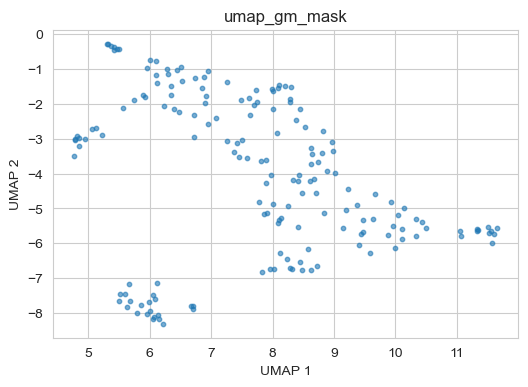


Evaluating clustering algorithms...


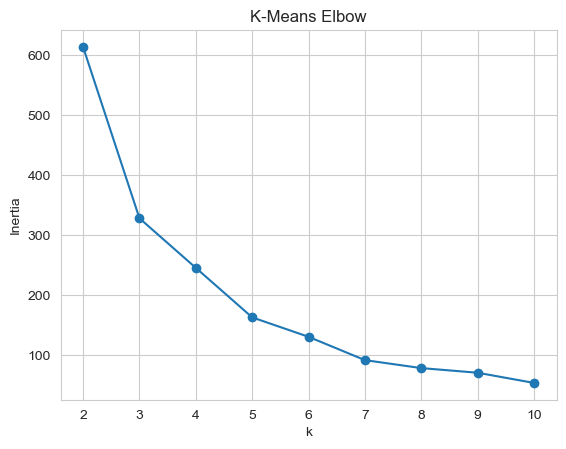

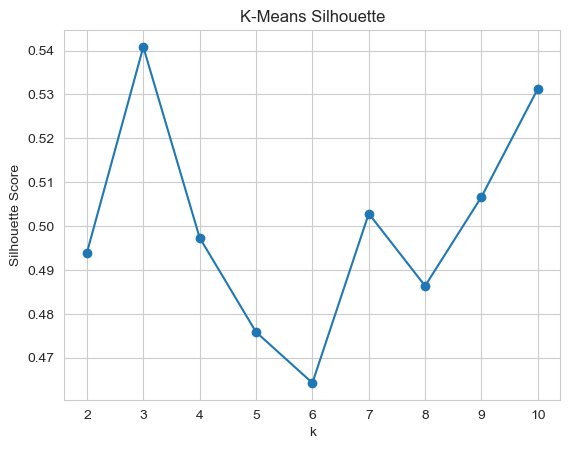

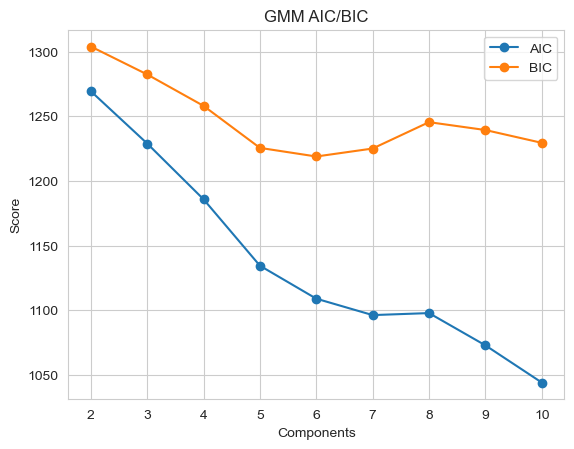

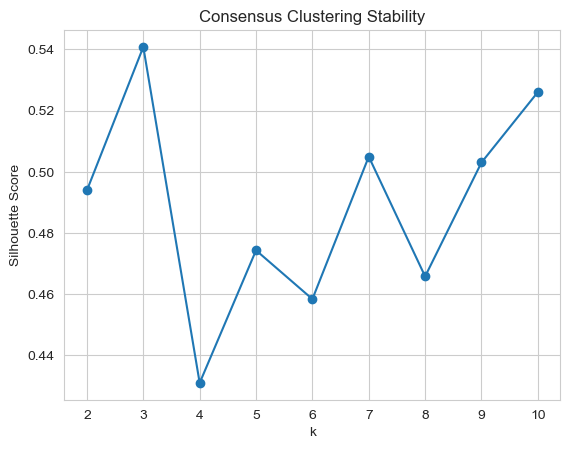



HDBSCAN found 9 clusters (excluding noise)

Clustering results


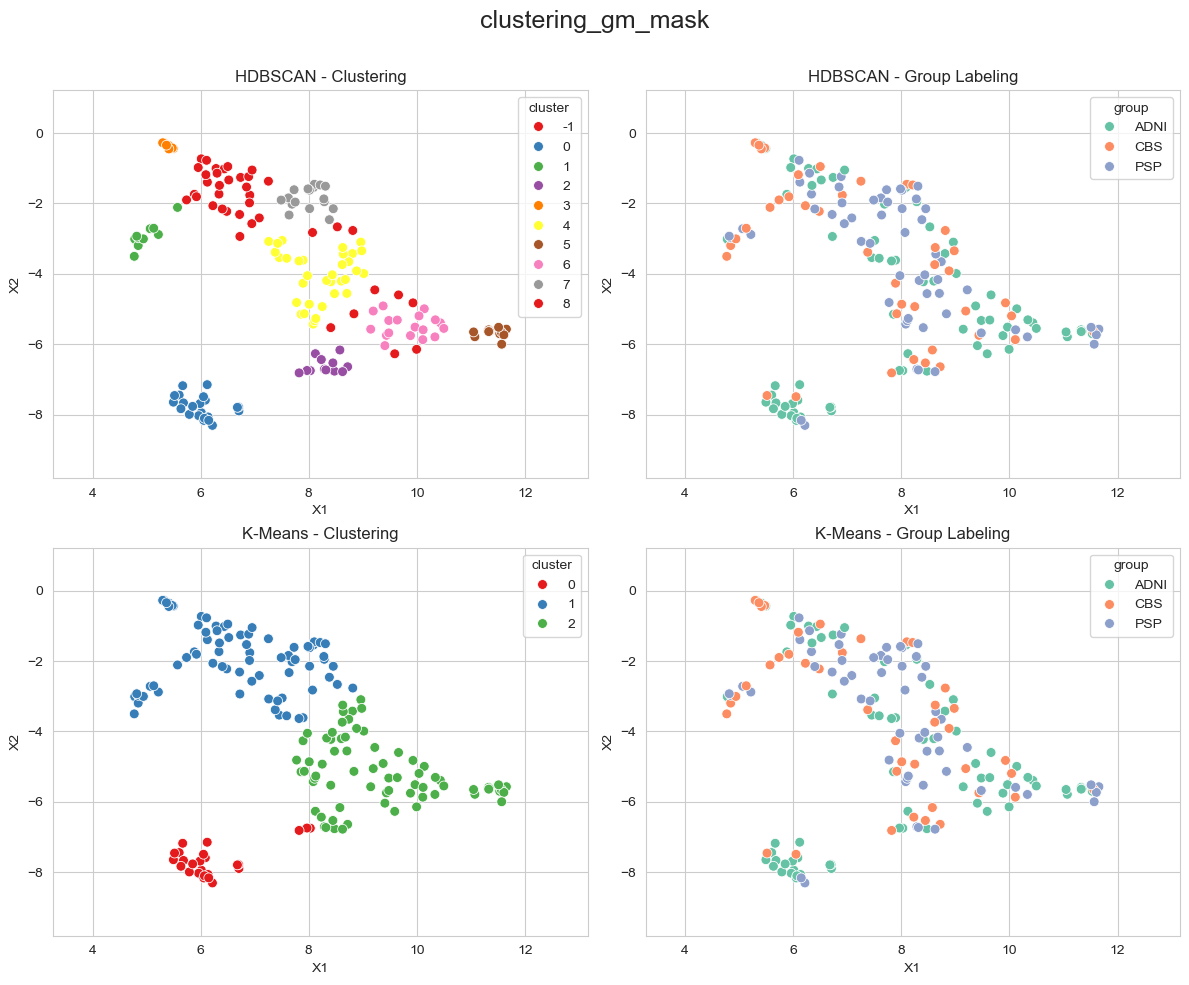

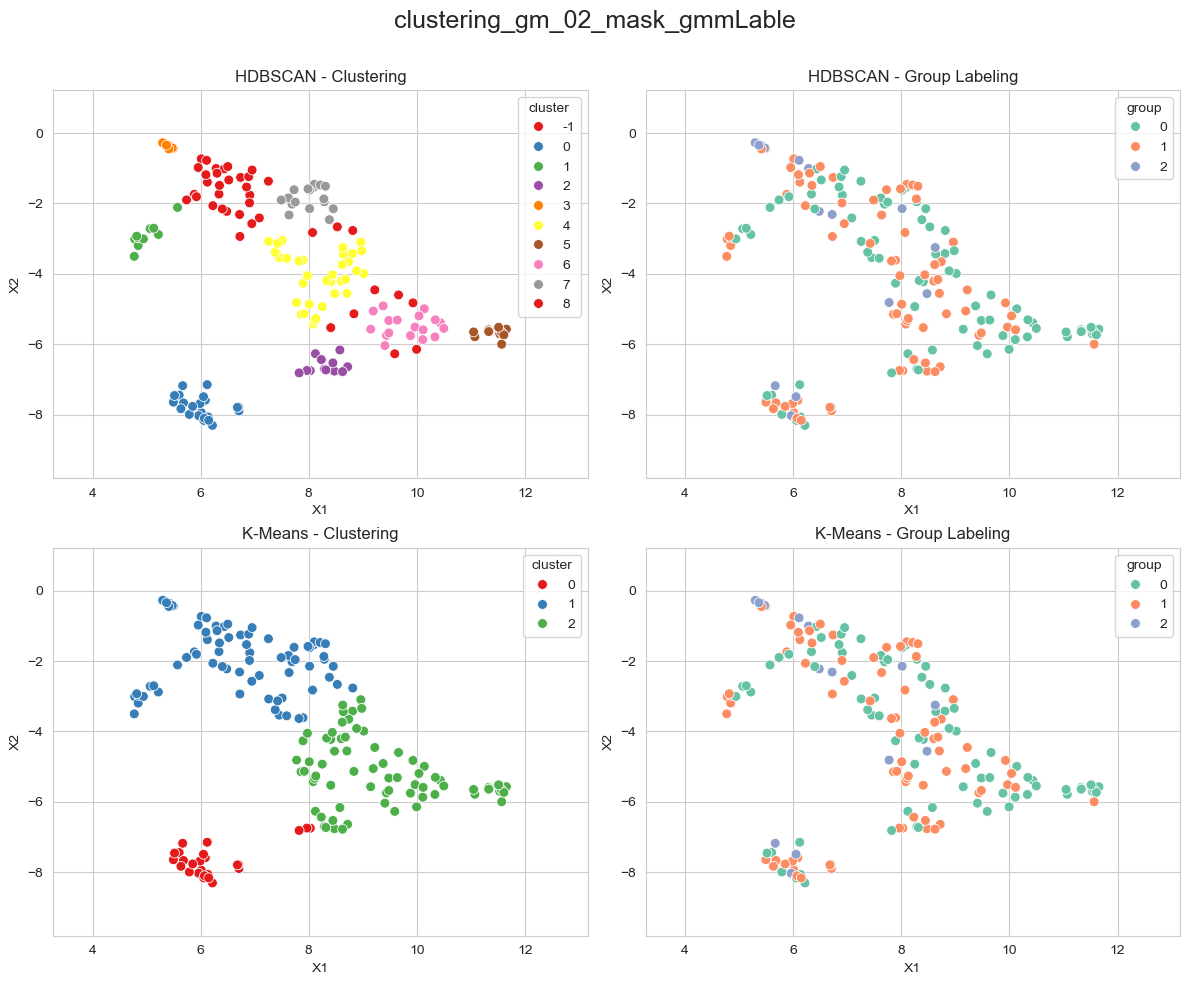

In [60]:
labeling, x_umap = main_clustering(df_gm_masked, df_meta,
                                        save_path = None,
                                        title_umap = "umap_gm_mask",
                                        title_cluster = "clustering_gm_mask",
                                        plot_flag=True,
                                        do_eval=True,
                                        eval_save_path=None)

In [ ]:
labeling, x_umap = main_clustering(df_thr02_gm_masked, df_meta,
                                        save_path = None,
                                        title_umap = "umap_gm_02_mask",
                                        title_cluster= "clustering_gm_02_mask",
                                        plot_flag=True,
                                        do_eval=True,
                                        eval_save_path=None)

In [ ]:
labeling, x_umap = main_clustering(df_thr01_gm_masked, df_meta,
                                        save_path = None,
                                        title_umap = "umap_gm_01_mask",
                                        title_cluster = "clustering_gm_01_mask",
                                        plot_flag=True,
                                        do_eval=True,
                                        eval_save_path=None)

In [ ]:
labeling, x_umap = main_clustering(df_thr01_har_masked, df_meta,
                                        save_path = None,
                                        title_umap = "umap_har_01_mask",
                                        title_cluster = "clustering_har_01_mask",
                                        plot_flag=True,
                                        do_eval=True,
                                        eval_save_path=None)

In [ ]:
labeling, x_umap = main_clustering(df_thr02_har_masked, df_meta,
                                        save_path = None,
                                        title_umap = "umap_har_02_mask",
                                        title_cluster = "clustering_har_02_mask",
                                        plot_flag=True,
                                        do_eval=True,
                                        eval_save_path=None)

In [ ]:
labeling, x_umap = main_clustering(df_har_masked, df_meta,
                                        save_path = None,
                                        title_umap = "umap_har_mask",
                                        title_cluster = "clustering_har_mask",
                                        plot_flag=True,
                                        do_eval=True,
                                        eval_save_path=None)

## Linear Regression

In [61]:
path_umap_regression = '/output/umap_regression'

### GMM distributions

In [62]:
for gmmLabel in range(0,3):
    mean_cdr = df_meta.loc[df_meta['GMM_Label'] == gmmLabel, 'CDR_SB'].mean()
    print(f"Media CDR_SB per gruppo {gmmLabel}: {mean_cdr:.3f}")

Media CDR_SB per gruppo 0: 1.406
Media CDR_SB per gruppo 1: 5.243
Media CDR_SB per gruppo 2: 12.267


In [63]:
# Select the subjects ID with a particular GMM_Label
gmm_ids = df_meta[df_meta['GMM_Label'] == 0]['ID']

# Filter the dataset
df_features = df_thr02_har_masked.copy()

df_masked_gmm = df_features[df_features['ID'].isin(gmm_ids)].reset_index(drop=True)
df_meta_gmm = df_meta[df_meta['ID'].isin(gmm_ids)].reset_index(drop=True)

In [ ]:
model, y_pred, residuals, subject_errors, group_rmse_stats = main_regression(
    df_masked = df_masked_gmm,
    df_meta = df_meta_gmm,
    target_variable = "CDR_SB",
    covariates = None,
    y_log_transform = False,
    plot_flag = True,
    save_path = None,
    title_prefix = "gm_mask_GMM"
)

### Run all

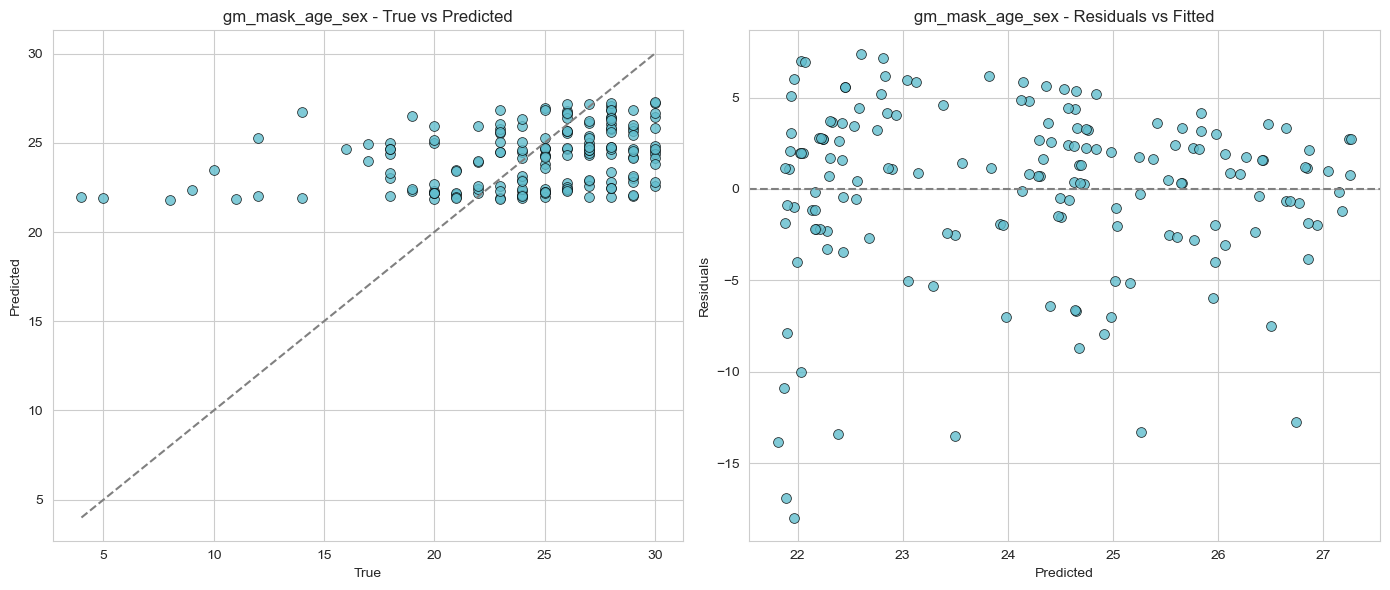

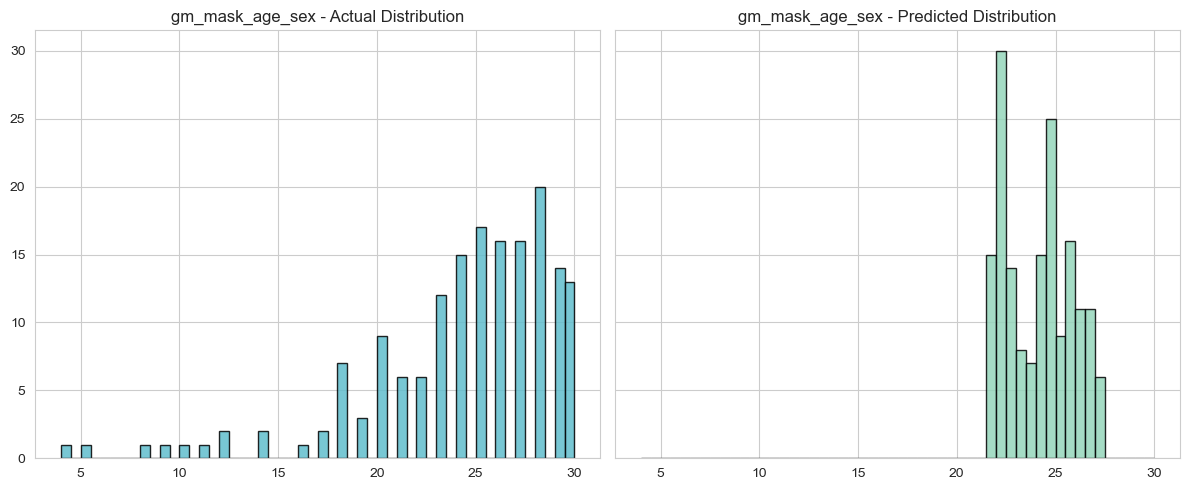

                            OLS Regression Results                            
Dep. Variable:                   MMSE   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     10.25
Date:                Wed, 28 May 2025   Prob (F-statistic):           6.39e-05
Time:                        18:50:29   Log-Likelihood:                -495.94
No. Observations:                 167   AIC:                             997.9
Df Residuals:                     164   BIC:                             1007.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         29.9150      2.381     12.562      0.0

In [68]:
model, y_pred, residuals, subject_errors, group_rmse_stats = main_regression(
    df_masked = df_gm_masked,
    df_meta = df_meta,
    target_variable = "MMSE",
    covariates = None,
    y_log_transform = False,
    plot_flag = True,
    save_path = None,
    title_prefix = "gm_mask_age_sex"
)

In [ ]:
model, y_pred, residuals, subject_errors, group_rmse_stats = main_regression(
    df_masked = df_thr01_gm_masked,
    df_meta = df_meta,
    target_variable = "MMSE",
    covariates = None,
    y_log_transform = False,
    plot_flag = True,
    save_path = None,
    title_prefix = "gm_mask_01"
)

In [ ]:
model, y_pred, residuals, subject_errors, group_rmse_stats = main_regression(
    df_masked = df_thr02_gm_masked,
    df_meta = df_meta,
    target_variable = "MMSE",
    covariates = None,
    y_log_transform = False,
    plot_flag = True,
    save_path = path_umap_regression,
    title_prefix = "gm_mask_02"
)

#### Txt files

In [ ]:
output_file = "/output/OLS_regression_GM_mask.txt"

with open(output_file, "w") as f:
    with contextlib.redirect_stdout(f):
        print("\n\n" + "="*70)
        print("   OLS Regression Results - GM Mask without Threshold ")
        print("="*70 + "\n")

        model, y_pred, residuals, subject_errors, group_rmse_stats = main_regression(
            df_masked = df_gm_masked,
            df_meta = df_meta,
            target_variable = "CDR_SB",
            covariates = None,
            y_log_transform = False,
            plot_flag = False,
            save_path = None
        )

        print("\n\n\n" + "="*70)
        print("   OLS Regression Results - GM Mask without Threshold ")
        print("   Covariates: Sex, Education, Age ")
        print("="*70 + "\n")

        model, y_pred, residuals, subject_errors, group_rmse_stats = main_regression(
            df_masked = df_gm_masked,
            df_meta = df_meta,
            target_variable = "CDR_SB",
            covariates = ["Sex", "Education", "Age"],
            y_log_transform = False,
            plot_flag = False,
            save_path = None
        )

        print("\n\n\n" + "="*70)
        print("   OLS Regression Results - GM Mask without Threshold ")
        print("   Covariates: Sex, Age ")
        print("="*70 + "\n")

        model, y_pred, residuals, subject_errors, group_rmse_stats = main_regression(
            df_masked = df_gm_masked,
            df_meta = df_meta,
            target_variable = "CDR_SB",
            covariates = ["Sex", "Age"],
            y_log_transform = False,
            plot_flag = False,
            save_path = None
        )